In [17]:
import numpy as np 
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
import time 
import graph_tool.all as gt
# import cupyx.scipy.sparse as csp, cupyx.scipy.sparse.linalg as cspl, cupy as cp

%matplotlib inline
from LinearSystems import *
from utils import * 
# from cupyx.scipy.fft import idstn, dstn
import scipy.fft as sfft

import pyvista as pv
# pv.set_jupyter_backend('trame')

In [18]:
class FastPoissonSolver:

    def __init__(self, grid:Grid, boundaryType='dirichlet', dstType:int=1):
        self.bc = boundaryType
        self.grid = grid
        self.n = np.array(grid.n)
        self.h = np.array(grid.h)
        self.dstType = dstType
        
    def eigenvalues(self):
        """Code taken from scipy's ``LaplacianND`` implementation."""
        indices = np.indices(self.n)
        Leig = np.zeros(self.n)

        for j, n, h in zip(indices, self.n, self.h):
            if self.bc=='dirichlet':
                Leig += -(4/(h**2)) * np.sin(np.pi * (j+1) / (2 * (n+1)))**2
            elif self.bc=='neumann':
                Leig += -(4/(h**2)) * np.sin(np.pi * j / (2*n)) ** 2
            else:
                Leig += -(4/(h**2)) * np.sin(np.pi * np.floor((j+1)/2) / n)**2
        return Leig
    
    def Solve(self, x):
        """Invert the laplacian operator using Fourier transforms."""
        eig = self.eigenvalues()
        eig = np.where(eig==0, np.inf, eig)
        x = x.reshape(self.grid.n)
        x = sfft.dstn(x, type=self.dstType, norm='ortho')
        x /= eig
        x = np.real(sfft.idstn(x, type=self.dstType, norm='ortho'))
        return x.ravel()  

In [34]:
convertMicron = 1e-4 # Converts microns to whatever unit we want to use

# Grid parameters
lx,ly,lz = 50 * convertMicron, 50 * convertMicron, 50 * convertMicron # Cube's sides lengths, in micron
cx,cy,cz = -lx/2., -ly/2., -lz/2. # Location of the bottom, left, back corner of the cube, in microns
h = 5 * convertMicron # Voxel size length
nx, ny, nz = [int(l/h) for l in (lx,ly,lz)]
# assert all(l/n==h for l,n in zip((lx,ly,lz), (nx,ny,nz))), f"Currently, the discretization assumes the voxels to be cubes (all sides must have the same length). Found {[l/n for l,n in zip((lx,ly,lz), (nx,ny,nz))]}"

# Physiological parameters
Hd = 0.45 # Haematocrit 
C0 = 0.02 # Mol/L (What is that?)
# alpha = 1.2e-6 # Mol/L/mmHg, oxygen plasma solubility
alpha = (2.82e-5 * 22.4e-3) * ((1e5)**3) # mol/mmHg/L from "Dynamic model of oxygen transport from capillaries to tissue with moving red blood cells.", converted to mol/mmHg/cm3
alpha_t = (3.89e-5 * 22.4e-3) * ((1e5)**3) # mol/mmHg/L from "Dynamic model of oxygen transport from capillaries to tissue with moving red blood cells.", converted to mol/mmHg/cm3
alpha, alpha_t = alpha * (convertMicron**3), alpha_t * (convertMicron**3)

alpha_t = alpha

Gamma_v = 6.5e-1 * (convertMicron**2) #8.78*1e2 * (convertMicron**2) # 1.77e3 * (convertMicron**2) # in mum2/s the permeability of the vessel wall to O2, converted to cm2/s
h_v = 0.5 * convertMicron # In microns, the vessel wall thickness
Gamma_t = 1.8e3 * (convertMicron**2) # in mum2/s the oxygen diffusivity in tissue, converted to cm2/s
k_t = 1e-4 * (convertMicron**-3) # M/s=(mol/m^3)/s, the oxygen consumption rates from Roberts et al 2015

# Boundary conditions
RO2 = 62.36 # Ideal gas constant for O2, L.mmHg/(K.Mol)
Tret = 308.15 # 35*C in Kelvin, the temperature of the retina (roughly)
cIn = 80 * alpha # mmHg to molO2/L = free plasma oxygen concentration
ctBC = 30 * alpha_t # / (RO2 * Tret)  # mmHg to molO2/L 

print(f"Boundary conditions: {cIn=}, {ctBC=}")
print(f"Dynamics parameters: {Gamma_t=}, {Gamma_v=}, {k_t*(h**3)=}")
print(f"Grid parameters: {(lx,ly,lz)=}, {(cx,cy,cz)=}, {h=} {(nx,ny,nz)=}")
print(f"Other parameters: {alpha=}, {alpha_t=}, {Gamma_t*alpha_t}")

Boundary conditions: cIn=0.05053440000000001, ctBC=0.018950400000000003
Dynamics parameters: Gamma_t=1.8e-05, Gamma_v=6.5e-09, k_t*(h**3)=0.0125
Grid parameters: (lx,ly,lz)=(0.005, 0.005, 0.005), (cx,cy,cz)=(-0.0025, -0.0025, -0.0025), h=0.0005 (nx,ny,nz)=(10, 10, 10)
Other parameters: alpha=0.0006316800000000001, alpha_t=0.0006316800000000001, 1.1370240000000002e-08


In [20]:

r0, r1 = 5 * convertMicron, 5 * convertMicron
v0 = 400e0 * convertMicron # micron/s
p0 = np.array([0.0, cx-ly/4., 0.0]) 
p1 = np.array([0.0, cx+5.*ly/4., 0.0]) 
n = (p1-p0)/np.linalg.norm(p0-p1, 2)
l = np.linalg.norm(p0-p1, 2)

k = 50

VAG = VascularGraph()
VAG.add_edge_list([(i,i+1,l/k, r0 + i*(r1-r0)/k) for i in range(k)], eprops=[('length', 'float'), ('radius','float')])
pos = VAG.new_vertex_property("vector<double>")
pos.set_2d_array(np.array([p0+t*(p1-p0) for t in np.linspace(0,1,endpoint=True, num=k+1)]).T)
VAG.vp['position'] = pos
VAG.vp['plexus'] = VAG.new_vertex_property("int", val=0)
VAG.vp['sort'] = VAG.new_vertex_property('int', vals=gt.topology.topological_sort(VAG))
VAG.ep['v'] = VAG.new_edge_property("float", v0)

# graphFile = "/home/remi/Desktop/IOVS-Paper-Varying-alpha/HaemodynamicsNoReordering/Haemodynamics-100OPP-1e6R-0.4alpha/sim_0_AV.graph"
# def ReadGraph(graphFile):
#     VAG = gt.Graph(directed=True)
#     with open(graphFile, 'r') as f:
#         line = f.readline()
#         while "# Nodes" not in line:
#             line = f.readline()
#         nNodes = int(line.strip().split(' ')[-1])
#         nodes = VAG.add_vertex(nNodes)
#         vps = f.readline().strip().split(',')
#         pos = VAG.new_vertex_property('vector<float>')
#         nodesPos = {n:np.array(list(map(float, p.strip('[').strip(']').split()))) 
#                     for n,p in map(lambda i: f.readline().strip().split(',')[:2], range(nNodes))}
#         nodesMap = {n:i for i,n in enumerate(nodesPos.keys())}
#         pos.set_2d_array(np.array([p for p in nodesPos.values()]).T, pos=(0,1,2))
#         VAG.vp['position'] = pos
#         del nodesPos
        
#         while "# Edges" not in line:
#             line = f.readline()
#         nEdges = int(line.strip().split(' ')[-1])
#         eps = f.readline().strip().split(',')
#         edgeList = np.array([(nodesMap[e[0]], nodesMap[e[1]], *[float(ei) if ei!='None' else 0 for ei in e[2:]]) 
#                             for e in map(lambda i: f.readline().strip().split(','), range(nEdges))])
#         VAG.add_edge_list(edge_list=edgeList, eprops=[(name, 'float') for name in eps[2:]]) 
#     return VAG

# VAG = ReadGraph(graphFile)

# gt.draw.graph_draw(VAG, pos=VAG.vp['position'])
CV = ControlVolumes(Grid(origin=(cx,cy,cz), 
                         sideLengths=(lx,ly,lz), 
                         shape=(nx,ny,nz)), 
                         vessels=VAG)

topoSort = SplitVessels(CV, CV.grid.h)

q = CV._vessels.new_edge_property("float") # Flow in the vessel (constant -- conservation of mass)
v = CV._vessels.new_edge_property("float", v0)
try: 
    q.a = CV._vessels.ep['flow'].a * 1e12 * (convertMicron**3) # cm^3/s to micron^3/s
    v.a = (1e4*convertMicron) * CV._vessels.ep['flow'].a / (np.pi*(CV._vessels.ep['radius'].a**2)) # cm/s to micron/s
except KeyError:
    q.a = v.a * (np.pi* (CV._vessels.ep['radius'].a**2))
CV._vessels.ep['q'] = q
CV._vessels.ep['v'] = v

C2v, C2t, N = CV.LabelMesh(h_v)
# CV.ToVTK("LabelGridOneVessel.vtk")

Pruning the coupling graph: 100%|██████████| 90/90 [00:00<00:00, 152028.74it/s]


In [21]:
S = MakeSurfaceScaling(CV, N) * Gamma_v/h_v

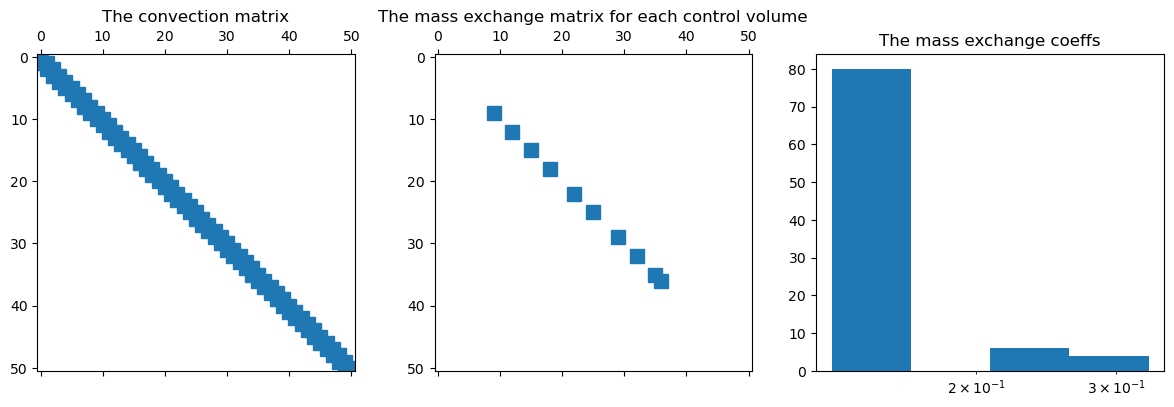

In [22]:
M, Min, Din = ConvectionMatrices(CV)
Convection = (sp.eye(Din.shape[0])-Din)@M + Min

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
ax1.spy(Convection)
ax1.set_title("The convection matrix")
ax2.spy(C2v.T@S@C2v)
ax2.set_title("The mass exchange matrix for each control volume")

bins = 5
logbins = np.logspace(np.log10((S.diagonal(0)/np.mean(abs(Convection.data[1:]))).min()), 
                      np.log10((S.diagonal(0)/np.mean(abs(Convection.data[1:]))).max()),
                      bins)
_ = ax3.hist(S.diagonal(0)/np.mean(abs(Convection.data[1:])), bins=logbins)
ax3.set_xscale('log')
ax3.set_title("The mass exchange coeffs")
plt.tight_layout()
plt.show()

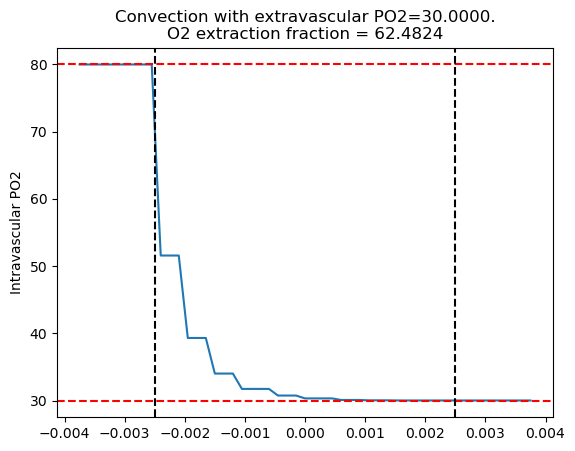

In [23]:
x = spl.spsolve(Convection + C2v.T@S@C2v, Din.diagonal(0)*cIn + C2v.T@S@C2t@(np.ones(CV.grid.size)*ctBC))

plt.plot([p[1] for p in CV._vessels.vp['position']], x/alpha,)
plt.axhline(cIn/alpha, c='r', ls='dashed')
plt.axhline(ctBC/alpha_t, c='r', ls='dashed')
plt.axvline(CV.grid.origin[1], c='k', ls='dashed')
plt.axvline(CV.grid.origin[1]+CV.grid.l[1], c='k', ls='dashed')
plt.ylabel("Intravascular PO2")
plt.title("Convection with extravascular PO2={:.4f}.\nO2 extraction fraction = {:.4f}".format(ctBC/alpha_t, 100*(cIn-x.min())/cIn))
plt.show()

In [24]:
B, D3, I3minusD3 = MakeDiffusionReaction(CV.grid, Gamma_t=Gamma_t, k_t=0*k_t)

cvBar = Din.diagonal(0)*cIn
ctBar = D3@(np.ones(CV.grid.size)*ctBC)

G = -I3minusD3 @ spl.aslinearoperator(C2t.T@S@C2v)
# B = I3minusD3 @ (B + spl.aslinearoperator(C2t.T@S1@C2t)) #+ D3


def GetDx(x):
    gridShape = tuple(CV.grid.n)
    N = len(gridShape)
    X = x.reshape(gridShape)
    y = np.zeros_like(X)
    y[0,...] = (X[0,...]-X[1,...])/CV.grid.h[0]
    y[-1,...] = (X[-2,...]-X[-1,...])/CV.grid.h[0]
    y[:,0,:] = (X[:,0,:]-X[:,1,:])/CV.grid.h[1]
    y[:,-1,:] = (X[:,-2,:]-X[:,-1,:])/CV.grid.h[1]
    y[...,0] = (X[...,0]-X[...,1])/CV.grid.h[2]
    y[...,-1] = (X[...,-2]-X[...,-1])/CV.grid.h[2]
    return y.ravel()
    
DNeumann = spl.LinearOperator(shape=B.shape, 
                              matvec = GetDx)
ctBar *= 0.0
# M0 = 1e-4 * 1e12 # In mol/(mum^3.s)
# M0 = 1.7*4.47*(10**-21)
# M0 *= (convertMicron**-3)
# print(M0, k_t)
# ctBar = I3minusD3 @ (np.prod(CV.grid.h)*np.ones(B.shape[1])*M0/2.) 
B = I3minusD3 @ (B*np.prod(CV.grid.h) + spl.aslinearoperator(C2t.T@S@C2t)) + DNeumann

In [25]:
A = Convection + C2v.T@S@C2v
E = -C2v.T@S@C2t

# def Sc_func(x):
#     '''Schur complement system'''
#     return 1.0*(B@x) + (G@spl.spsolve_triangular(A, E@x)) 
# def Make_bc(bv, bt):
#     '''Make the bc for the Schur complement system'''
#     return bt - G@(spl.spsolve_triangular(A, bv))
# def cv_func(ct, cvBar):
#     return spl.spsolve_triangular(A, cvBar - E@ct)

# Sc = spl.LinearOperator(shape=2*(CV.grid.size,), matvec=Sc_func)

In [26]:
# bc = Make_bc(cvBar, ctBar)
y = np.hstack([cvBar, ctBar])

nv = A.shape[0]
K = spl.LinearOperator(shape=2*(A.shape[0]+B.shape[0],), 
                       matvec=lambda x: np.hstack([A@x[:nv]+E@x[nv:],
                                                   G@x[:nv]+B@x[nv:]]))

In [27]:
def P00(x):
    '''Preconditionner for the block [0,0] of the full system.'''
    return spl.spsolve(A, x)
    

fps = FastPoissonSolver(CV.grid, 'neumann')
_P = lambda y: np.hstack([
    P00(y[:A.shape[1]]),
    fps.Solve(y[A.shape[1]:])
]) 
P = spl.LinearOperator(shape=K.shape, matvec=_P) # does not improve convergence, even reduces it

In [28]:
class gmres_counter(object):
    def __init__(self, A, y, disp=10, _print:bool=True):
        self._disp = disp
        self._print = _print
        self.niter = 0
        self.rks = []
        self.A = A
        self.y = y
        self.norm_y = np.linalg.norm(self.y)

    def __call__(self, x):
        self.niter += 1
        if self.niter%self._disp==0:
            rk = np.linalg.norm(self.A@x-self.y)/self.norm_y
            self.rks.append(rk)
            if self._print:
                print('iter %3i\trk = %s' % (self.niter, str(rk)))

    def __enter__(self):
        self.t1 = time.time()
        return self
    def __exit__(self, type, value, traceback):
        t = (time.time() - self.t1)/60
        plt.plot(self._disp * (1+np.arange(len(self.rks))), self.rks)
        plt.xlabel("Number of iterations")
        plt.ylabel("Residual (relative?)")
        plt.title(f"Solving time: {t:.4f}min")

Exited with code 0


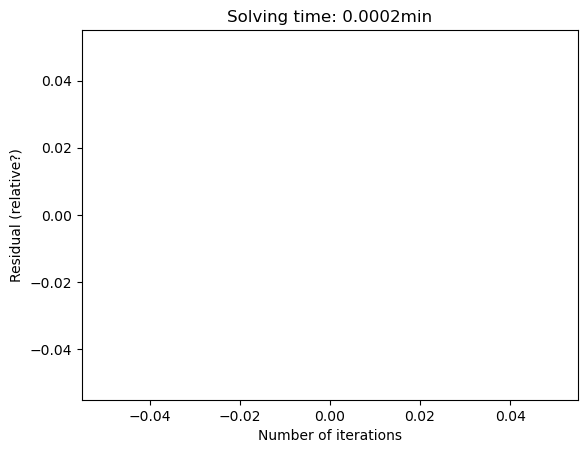

In [29]:
with gmres_counter(K, y, disp=100) as callback:
    x, code = spl.gmres(K, y, x0=x if x.shape==K.shape[0] else None, 
                        # M=P,
                        callback=callback, callback_type='x',
                        restart=10, maxiter=2_000, tol=1e-8)
    print("Exited with code", code)
cv,ct = x[:nv]/alpha, x[nv:]/alpha_t

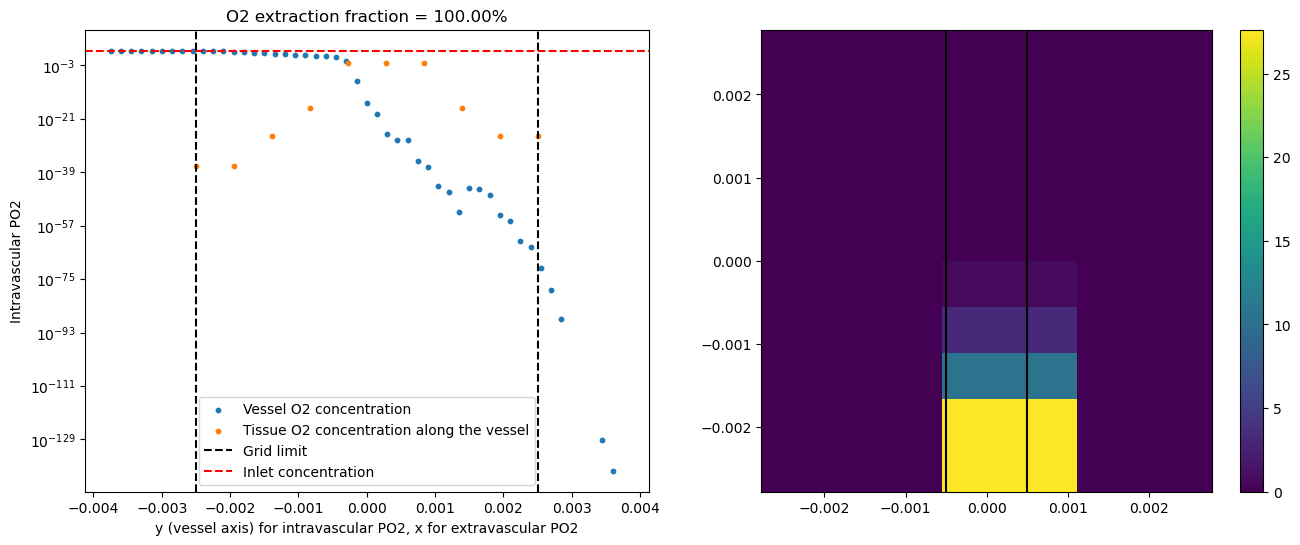

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.scatter(np.linspace(p0[1], p1[1], len(cv), endpoint=True), cv, s=10, label="Vessel O2 concentration")
ax1.scatter(np.linspace(CV.grid.origin[0], CV.grid.origin[0]+CV.grid.l[0], CV.grid.n[0], endpoint=True), 
            ct.reshape(CV.grid.shape)[:, ny//2, ny//2], label='Tissue O2 concentration along the vessel', s=10)
ax1.set_xlabel("y (vessel axis) for intravascular PO2, x for extravascular PO2")
ax1.axvline(CV.grid.origin[1], c='k', ls='dashed', label="Grid limit")
ax1.axvline(CV.grid.origin[1]+CV.grid.l[1], c='k', ls='dashed')
ax1.axhline(cIn/alpha, c='r', ls='--', label='Inlet concentration')
# ax1.axhline(ctBC/alpha_t, c='r', ls='dotted', label='Tissue boundary concentration (if used)')
ax1.legend()
ax1.set_ylabel("Intravascular PO2")
ax1.set_yscale('log')
# ax1.set_title("Convection with extravascular PO2={:.4f}.\nO2 extraction fraction = {:.4f}".format(ctBC/alpha_t, 100*(cIn-cv.min()*alpha)/cIn))
ax1.set_title("O2 extraction fraction = {:.2f}%".format(100*(cIn-cv.min()*alpha)/cIn))

X,Y = np.meshgrid(np.linspace(cx, cx+lx, nx, endpoint=True),
                  np.linspace(cy, cy+ly, ny, endpoint=True),indexing='ij')
cm = ax2.pcolormesh(X,Y, ct.reshape(CV.grid.shape)[:,:,nz//2], norm='linear')
ax2.axvline(-r0, c='k')
ax2.axvline(r0, c='k')
plt.colorbar(cm)
plt.show()


In [31]:
# grid = pv.ImageData()
# grid.dimensions = CV.grid.shape + 1
# grid.origin = CV.grid.origin 
# grid.spacing = CV.grid.h
# grid.cell_data['PO2'] = ct.reshape(CV.grid.shape).flatten(order='F') / alpha_t

# cylinder = pv.Cylinder(center=[0, cy+ly/2, 0], 
#                        direction=[0,1,0], radius=min(lx,lz)/2., height=2*ly).extract_surface().triangulate()
# vessel = pv.Cylinder(center=[0, cy+ly/2, 0], 
#                        direction=[0,1,0], radius=r0, height=2*ly).extract_surface().triangulate()

# WithoutVessel = cylinder.boolean_difference(vessel)
# box = pv.Box(bounds=[0, 2*lx, cy-1, cy+2*ly, cz+lx/2., 2*lz])
# clip = grid.clip_surface(WithoutVessel)
# clip = clip.clip_box(box)

# p = pv.Plotter(notebook=1,)
# p.add_axes()
# # p.add_mesh(grid, show_edges=True, opacity=.5)
# # p.add_mesh(cylinder, color='red', opacity=1)
# p.add_mesh(clip, show_edges=False, show_scalar_bar=True, log_scale=True)
# # p.add_volume(clip, show_scalar_bar=True, log_scale=True)
# p.show()

# Krogh's model

# Preconditionner

In [32]:
def P00(x):
    '''Preconditionner for the block [0,0] of the full system.'''
    return spl.spsolve(A, x)
    

fps = FastPoissonSolver(CV.grid)
_P = lambda y: np.hstack([
    P00(y[:A.shape[1]]),
    fps.Solve(y[A.shape[1]:])
]) 
P = spl.LinearOperator(shape=K.shape, matvec=_P) # does not improve convergence, even reduces it